In [1]:
from thesis_common import *
from consistency_detector_dataset import *

import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams['figure.dpi'] = 125 # increase plot sizes!

In [2]:
input_size = 42
hidden_size = 21
output_size = 1

# 1. Train "Subjects" with different Activation Functions

In [3]:
tanh_subjects = []
sigmoid_subjects = []
number_of_subjects = 10
epochs = 200
lr = 0.04

for i in range(number_of_subjects):
    (w1, w2) = initialize_random_subject(input_size, hidden_size, output_size)
 
    print "************************ Subject {} **********************************".format(i)
    
    (epoch, accuracy) = train_and_test_at_intervals_clone_weights(w1, w2, epochs, lr, torch.tanh, training_scenarios, testing_scenarios_all, hidden_size)
    tanh_subjects.append((epoch,accuracy))

    (epoch, accuracy) = train_and_test_at_intervals_clone_weights(w1, w2, epochs, lr, torch.sigmoid, training_scenarios, testing_scenarios_all, hidden_size)
    sigmoid_subjects.append((epoch,accuracy))

************************ Subject 0 **********************************
Epoch: 0 loss 4.03015518188
Epoch: 0 loss 2.41472578049
************************ Subject 1 **********************************
Epoch: 0 loss 7.89414024353
Epoch: 0 loss 4.87260723114
************************ Subject 2 **********************************
Epoch: 0 loss 14.0751791
Epoch: 0 loss 4.99407863617
************************ Subject 3 **********************************
Epoch: 0 loss 8.24860286713
Epoch: 0 loss 5.65750169754
************************ Subject 4 **********************************
Epoch: 0 loss 11.8254966736
Epoch: 0 loss 3.07446718216
************************ Subject 5 **********************************
Epoch: 0 loss 7.16080951691
Epoch: 0 loss 3.80153799057
************************ Subject 6 **********************************
Epoch: 0 loss 8.30141925812
Epoch: 0 loss 3.02893590927
************************ Subject 7 **********************************
Epoch: 0 loss 8.32235336304
Epoch: 0 loss 2.8870205

### Get the Mean and Error for each epoch across the subjects

In [11]:
(tanh_means, tanh_stds) = get_mean_and_sems(tanh_subjects)
(sigmoid_means, sigmoid_stds) = get_mean_and_sems(sigmoid_subjects)
x = tanh_subjects[0][0]

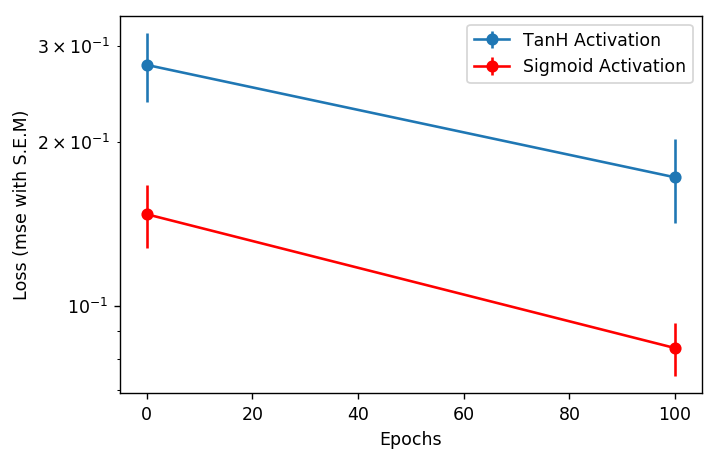

In [12]:
plt.errorbar(x, tanh_means, tanh_stds, fmt='-o', label='TanH Activation')
plt.errorbar(x, sigmoid_means, sigmoid_stds, fmt='-ro', label='Sigmoid Activation')
plt.legend()
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse with S.E.M.)')
plt.show()

---
# 2. Train "Subjects" and test accuracy at differing learning rates

In [ ]:
lr_subjects = {}
number_of_subjects = 10
epochs = 200

for i in range(number_of_subjects):
    (w1, w2) = initialize_random_subject(input_size, hidden_size, output_size)  

    print "************************ Subject {} **********************************".format(i)
    
    for dlr in range(1,8):
        lr = round(0.1 * dlr, 1)
        
        if lr not in lr_subjects:
            lr_subjects[lr] = []
        
        (epoch, accuracy) = train_and_test_at_intervals_clone_weights(w1, w2, epochs, lr, torch.sigmoid, testing_scenarios_all, training_scenarios, hidden_size)
        lr_subjects[lr].append((epoch,accuracy))

In [ ]:
x = lr_subjects.itervalues().next()[0][0]

In [18]:
print x

[0, 100]


In [ ]:
export_for_r_columns = [x]
for k in sorted(lr_subjects):
    (means, stds) = get_mean_and_sems(lr_subjects[k]) 
    export_for_r_columns = np.vstack((export_for_r_columns, means))
    plt.plot(x, means, label = str(k))

plt.legend()
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse with S.E.M.)')

plt.show()

# 3. Compare Inference vs No-Inference Performance
Use (0.4 LR, Sigmoid, and 800 epochs)

In [ ]:
inf_subjects = []
no_inf_subjects = []
number_of_subjects = 100
epochs = 501
lr = 0.4
activation = torch.sigmoid

for i in range(number_of_subjects):
    (w1, w2) = initialize_random_subject(input_size, hidden_size, output_size)  
 
    print "************************ Subject {} **********************************".format(i)
    
    (epoch, accuracy) = train_and_test_at_intervals_clone_weights(w1, w2, epochs, lr, activation, testing_scenarios_inference_required, training_scenarios, hidden_size, 2)
    inf_subjects.append((epoch,accuracy))
    
    (epoch, accuracy) = train_and_test_at_intervals_clone_weights(w1, w2, epochs, lr, activation, testing_scenarios_no_inference_required, training_scenarios, hidden_size, 2)
    no_inf_subjects.append((epoch,accuracy))

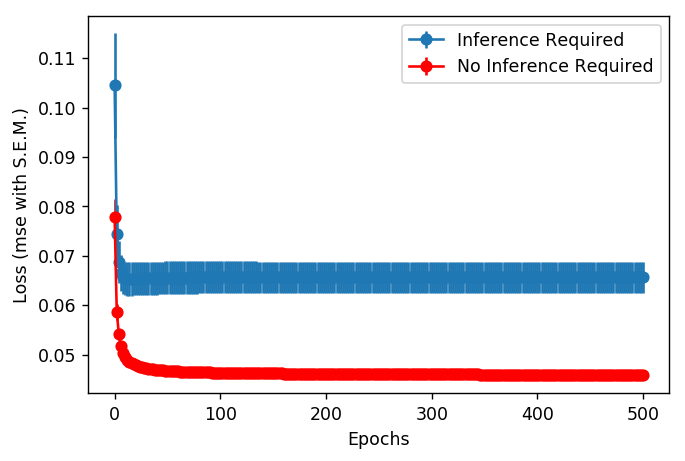

In [8]:
x = inf_subjects[0][0]
(inf_means, inf_stds) = get_mean_and_sems(inf_subjects)
(no_inf_means, no_inf_stds) = get_mean_and_sems(no_inf_subjects)

plt.errorbar(x, inf_means, inf_stds, fmt='-o', label='Inference Required')
plt.errorbar(x, no_inf_means, no_inf_stds, fmt='-ro', label='No Inference Required')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (mse with S.E.M.)')
plt.show()

___

### Are these two groups significantly different (They look like it)... Perform a t-test on the last (most trained) performance

In [9]:
inf_last_losses = [subject[1][-1] for subject in inf_subjects]
no_inf_last_losses = [subject[1][-1] for subject in no_inf_subjects]

##### First let's check for normality...

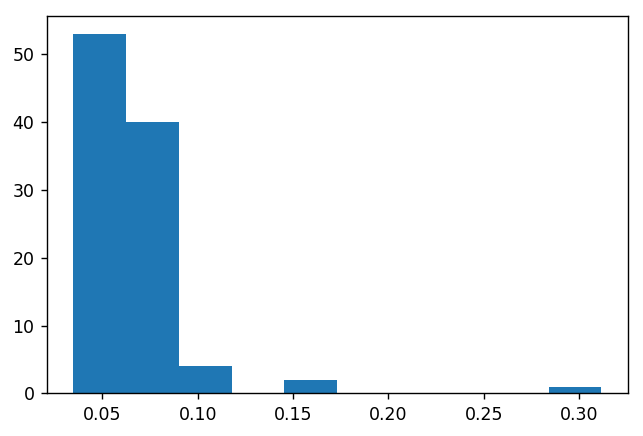

In [10]:
plt.hist(inf_last_losses)
plt.show()

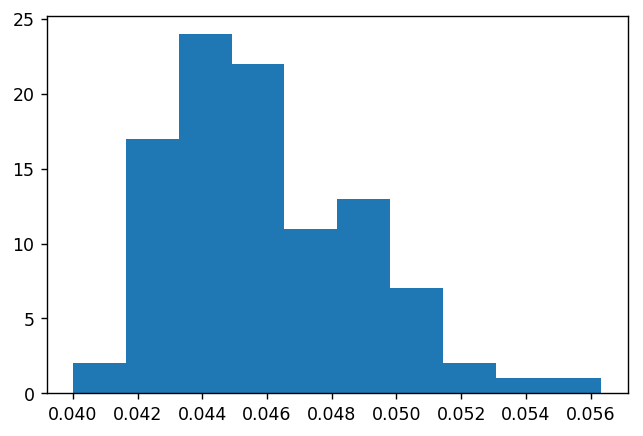

In [11]:
plt.hist(no_inf_last_losses)
plt.show()

### These histograms aren't ideal normal distributions, here we test for normality explicitly a couple of ways...

In [12]:
k2, p1 = scipy.stats.normaltest(inf_last_losses)
foo, p2 = scipy.stats.jarque_bera(inf_last_losses)
print "p1 = {}, p2 = {}".format(p1, p2)

p1 = 1.28321162846e-32, p2 = 0.0


In [13]:
k2, p1 = scipy.stats.normaltest(no_inf_last_losses)
foo, p2 = scipy.stats.jarque_bera(no_inf_last_losses)
print "p1 = {}, p2 = {}".format(p1, p2)

p1 = 0.00374489184304, p2 = 0.00332828400793


### These P-values aren't super great, but the number of samples is reasonably large (>50) so t-test should be ok, we'll follow up with a couple of non parametric tests too...

In [14]:
t, p = scipy.stats.ttest_ind(inf_last_losses, no_inf_last_losses
                 , equal_var=False)

print "p = {}. t = {}".format(p, t)

p = 1.32764355318e-08. t = 6.18712056375


### A Mann Whitney U test...

In [15]:
statistic, p = scipy.stats.mannwhitneyu(inf_last_losses, no_inf_last_losses)

print "p = {}. statistic = {}".format(p, statistic)

p = 5.38843364863e-19. statistic = 1387.0


### A Wilcoxon signed rank test

In [16]:
t, p = scipy.stats.wilcoxon(inf_last_losses, no_inf_last_losses)

print "p = {}. t = {}".format(p, t)

p = 3.53719535503e-15. t = 236.0


## These tests indicate the two groups are significantly different

---
# EXPERIMENTAL 

---
# Inspect Individual Network

In [43]:
def test_and_plot_losses(w1, w2, testing_scenarios):
    longest = max(testing_scenarios, key=lambda coll: len(coll[1]))
    x_axis = np.arange(len(longest[1]))
    
    for scenario in testing_scenarios:
        context_state = Variable(torch.zeros((1, hidden_size)).type(torch.FloatTensor), requires_grad=False)
        x = Variable(torch.FloatTensor(scenario[1]), requires_grad=False)
        y = scenario[2]
        
        event_losses = []
        for i in range(len(x)):
            inp = x[i:i+1]
            (output, new_context_state) = forward(inp, context_state, w1, w2, torch.sigmoid)
            context_state = Variable(new_context_state.data)
            
            prediction = output.data.numpy().ravel()[0]
            expected = y[i][0]
            
            event_losses.append(loss_measure(prediction, expected))
            
        plt.plot(x_axis[:(len(event_losses))], event_losses, label=scenario[0])
    
    plt.yscale('log')
    plt.legend()
    plt.show()

In [42]:
def test_and_report(w1, w2, testing_scenarios):
    test_loss = 0
    for scenario in testing_scenarios:
        print "-------------------------"
        print "{}".format(scenario[0])
        print "-------------------------"

        context_state = Variable(torch.zeros((1, hidden_size)).type(torch.FloatTensor), requires_grad=False)
        x = Variable(torch.FloatTensor(scenario[1]), requires_grad=False)
        y = scenario[2]
        
        scenario_loss = 0
        for i in range(len(x)):
            inp = x[i:i+1]
            (output, new_context_state) = forward(inp, context_state, w1, w2, torch.sigmoid)
            context_state = Variable(new_context_state.data)
            
            prediction = output.data.numpy().ravel()[0]
            prediction_rounded = int(round(prediction))
            expected = y[i][0]
            
            event_loss = loss_measure(prediction, expected)
            scenario_loss += event_loss
            test_loss += event_loss
            
            print "{:02d} | {:0.2f} == {} | {} | {:0.6f} {}".format(i, prediction, prediction_rounded, expected, event_loss, "" if prediction_rounded == expected else "*** MISMATCH ***")

        print "-------------------------"
        print " * Scenario Loss: {:0.6f}".format(scenario_loss / len(x))
        print "-------------------------"
        print ""
    
    print "------------------------------------------------------------"
    print " * Total Test Loss: {:0.6f}".format(test_loss / len(testing_scenarios))
    print "------------------------------------------------------------"

### 1. Train

In [44]:
epochs = 200
lr = 0.04
activation = torch.sigmoid

(w1, w2) = initialize_random_subject()
w1 =  Variable(w1, requires_grad=True)
w2 =  Variable(w2, requires_grad=True)
    
train(w1, w2, epochs, lr, activation)

Epoch: 0 loss 2.04970431328


### 2. Test the Network (w1, w2) on Non Inference Req

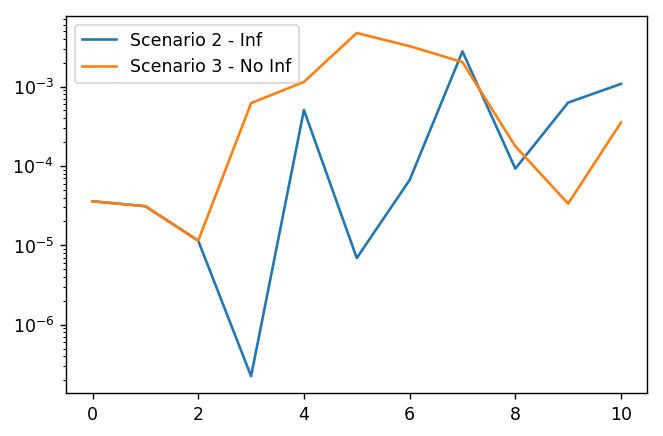

In [102]:
s = [('Scenario 2 - Inf', xS2Con, yS2Con),
     ('Scenario 3 - No Inf', xS3Con, yS3Con)]

test_and_plot_losses(w1, w2, s)

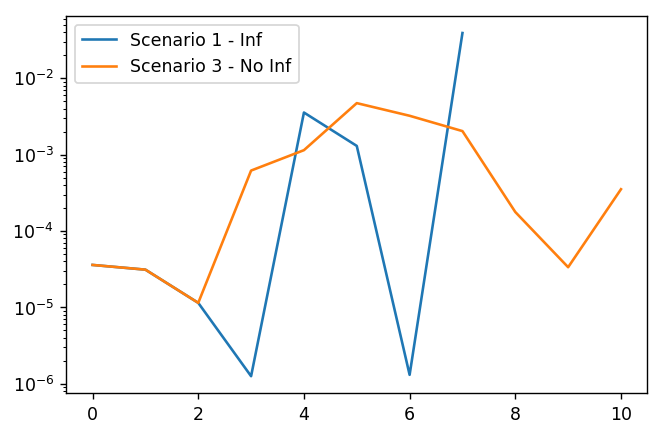

In [101]:
s = [('Scenario 1 - Inf', xS1Con, yS1Con),
     ('Scenario 3 - No Inf', xS3Con, yS3Con)]

test_and_plot_losses(w1, w2, s)

### 3. Test the Network on Inference Required

In [ ]:
test_and_report(w1, w2, testing_scenarios_no_inference_required)

### 4. Test consistent scenarios, Inf vs No Inf, Show Error Progression

In [ ]:
test_and_report(w1, w2, testing_scenarios_inference_required)